In [1]:
!pip install GEOparse
import GEOparse
print("The Dataset is getting download")

gse = GEOparse.get_GEO( geo="GSE19804",destdir=".") # where should i save my current file = . which means save in the current directory

print("Download completed!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


12-Jan-2026 21:19:22 DEBUG utils - Directory . already exists. Skipping.
12-Jan-2026 21:19:22 INFO GEOparse - File already exist: using local version.
12-Jan-2026 21:19:22 INFO GEOparse - Parsing .\GSE19804_family.soft.gz: 
12-Jan-2026 21:19:22 DEBUG GEOparse - DATABASE: GeoMiame
12-Jan-2026 21:19:22 DEBUG GEOparse - SERIES: GSE19804
12-Jan-2026 21:19:22 DEBUG GEOparse - PLATFORM: GPL570


C:\Users\Samrath Narula\AppData\Local\Programs\Python\Python314\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494556
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494557
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494558
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494559
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494560
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494561
12-Jan-2026 21:19:24 DEBUG GEOparse - SAMPLE: GSM494562
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494563
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494564
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494565
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494566
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494567
12-Jan-2026 21:19:25 DEBUG GEOparse - SAMPLE: GSM494568
12-J

Download completed!


In [2]:
import os
print(os.path.exists("GSE19804_family.soft.gz"))

True


In [4]:

#IMPORT LIBRARIES
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [5]:
gse = GEOparse.get_GEO(filepath="GSE19804_family.soft.gz")
print("Dataset loaded")
print("Total samples:", len(gse.gsms))



12-Jan-2026 21:20:43 INFO GEOparse - Parsing GSE19804_family.soft.gz: 
12-Jan-2026 21:20:43 DEBUG GEOparse - DATABASE: GeoMiame
12-Jan-2026 21:20:43 DEBUG GEOparse - SERIES: GSE19804
12-Jan-2026 21:20:43 DEBUG GEOparse - PLATFORM: GPL570
C:\Users\Samrath Narula\AppData\Local\Programs\Python\Python314\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
12-Jan-2026 21:20:45 DEBUG GEOparse - SAMPLE: GSM494556
12-Jan-2026 21:20:45 DEBUG GEOparse - SAMPLE: GSM494557
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494558
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494559
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494560
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494561
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494562
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: GSM494563
12-Jan-2026 21:20:46 DEBUG GEOparse - SAMPLE: 

Dataset loaded
Total samples: 120


In [6]:

#CREATE EXPRESSION MATRIX AND CREATE LABELS 
df = gse.pivot_samples("VALUE").T
print("Gene expression shape:", df.shape)
print(df.head())

#CREATE LABELS 
labels = []
for sample_id in df.index:
    title = gse.gsms[sample_id].metadata["title"][0].lower()   

    if "cancer" in title or "tumor" in title:     #(0 = Normal, 1 = Cancer)
        labels.append(1)
    else:
        labels.append(0)

df["Diagnosis"] = labels

print("Class distribution=")
print(df["Diagnosis"].value_counts())


Gene expression shape: (120, 54675)
ID_REF     1007_s_at  1053_at   117_at   121_at  1255_g_at  1294_at  1316_at  \
name                                                                           
GSM494556    11.9628  7.05652  6.55585  8.43850    3.73169  9.21781  5.65081   
GSM494557    11.3878  7.33711  6.96023  8.51636    3.77978  8.68893  5.59373   
GSM494558    11.1928  7.26121  7.14488  8.43138    3.99853  9.53345  5.39758   
GSM494559    11.9036  7.91211  7.13887  8.67404    3.69171  8.28728  5.87546   
GSM494560    11.7523  8.27448  7.72479  8.78145    3.93509  8.35532  5.76576   

ID_REF     1320_at  1405_i_at  1431_at  ...  AFFX-r2-Bs-thr-M_s_at  \
name                                    ...                          
GSM494556  6.26584    9.24805  4.07407  ...               10.81930   
GSM494557  5.72866    8.83435  4.48415  ...                9.81280   
GSM494558  5.69869   10.68300  4.46467  ...               12.45280   
GSM494559  5.75049    8.85718  4.58431  ...          

In [13]:

# SElECTING FEATURES & TARGET
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]
gene_variance = X.var()  #It will compute variance of each gene ie column across all samples.
topgenes = gene_variance.sort_values(ascending=False).head(500).index # REDCUING ALL DATA GENE INTO TOP 500 
X = X[topgenes]
print("Total new genes", X.shape[1])

#SCALING THE DATA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Total new genes 500


In [12]:

# splitting into TRAIN-TEST 
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.8, random_state=19)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy judegement ", accuracy)

Logistic Regression Accuracy judegement  0.96875


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Model judegement", accuracy)

Model judegement 1.0


Variance explaintion through pca= [0.34929519 0.12430681]


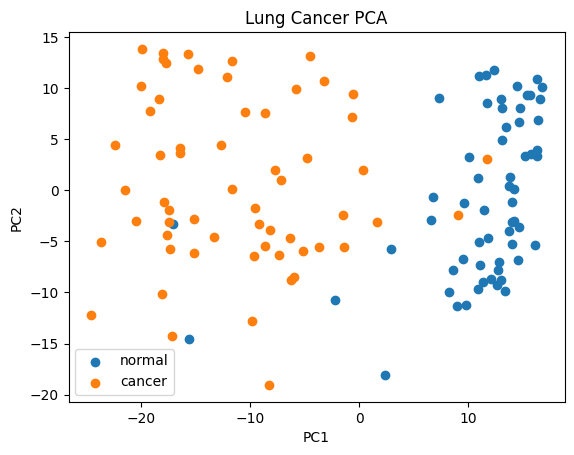

In [10]:
# PLOT
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(2) 
X_pca = pca.fit_transform(X_scaled)

print("Variance explaintion through pca=", pca.explained_variance_ratio_)

plt.scatter(X_pca[y==0,0], X_pca[y==0,1], label="normal")
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], label="cancer")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Lung Cancer PCA")
plt.legend()
plt.show()
